In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# Dataset and Dataloader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [4]:
train_set

Dataset ImageFolder
    Number of datapoints: 40000
    Root location: data/train/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [5]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([128, 1, 28, 28])

In [6]:
images

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [12]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur & Config

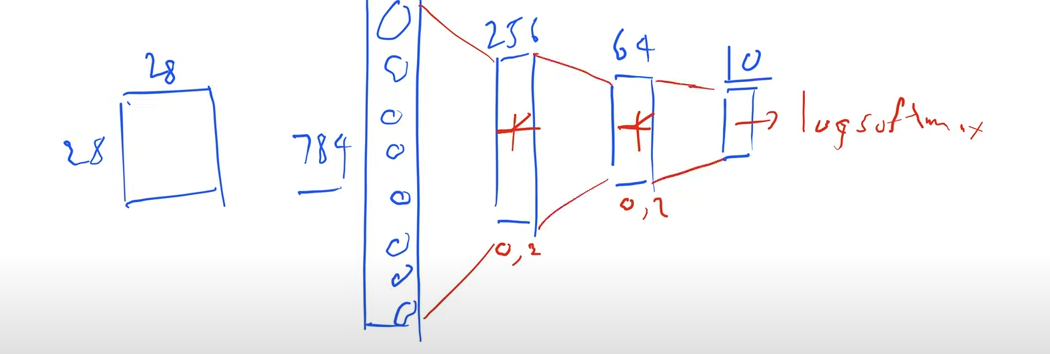

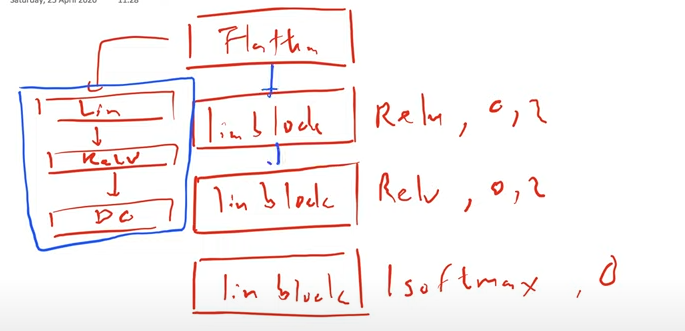

In [13]:
from jcopdl.layers import linear_block

In [15]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation="lsoftmax")
        )
    def forward(self, x):
        return self.fc(x)

In [16]:
# parameter itu di save. config -> apapun yang kita save dalam training kita bentuknya dict
config = set_config({ 
    "input_size":784,
    "n1":256,
    "n2":64,
    "output_size": len(train_set.classes),
    "dropout": 0.2
})

# Training Preparation -> MCOC

In [17]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model')

# Training

In [18]:
from tqdm.auto import tqdm

# def loop_fn(mode, dataset,dataloader, model, criterion, optimizer):
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == "train":
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature, target
#         feature, target = feature, target
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [ ]:
while True:
#     cost, acc = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    with torch.no_grad():
#         cost, acc = loop_fn("test", test_set, testloader, model, criterion, optimizer)
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer)
    # logging 
    callback.log(train_cost, test_cost, train_score, test_score)
    
    #checkpoint
    callback.save_checkpoint()
    
    #Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

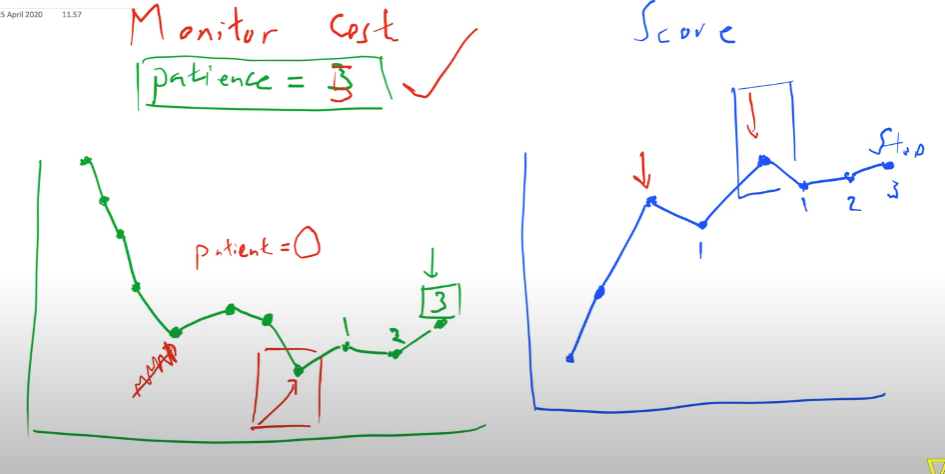

# Load Best Model

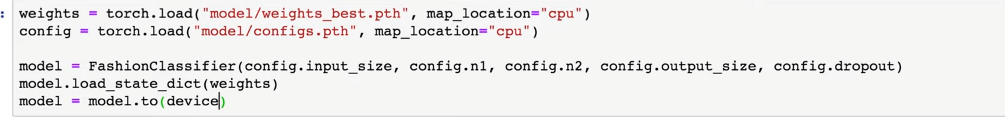

# Predict

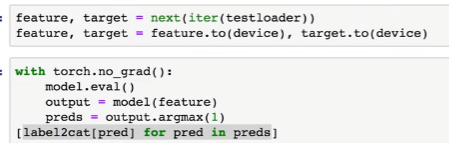

# Visualization

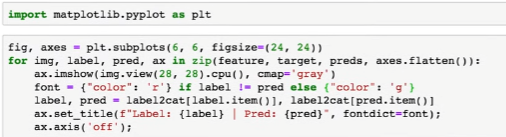

In [19]:
torch.no_grad()

In [2]:
import pandas as pd
import os
import seaborn as sns

In [5]:
kelas = []
n_gmbar = []
data = {'JenisTanaman':[], 'JumlahFoto':[]}

for i in os.listdir('data/test'):
    n_gmbar.append(len(os.listdir('data/test/'+i)))
    kelas.append(i)
    
data['JenisTanaman']+=kelas
data['JumlahFoto']+=n_gmbar

df = pd.DataFrame(data)
df

,JenisTanaman,JumlahFoto
0,Ankle boot,2000
1,Bag,2000
2,Coat,2000
3,Dress,2000
4,Pullover,2000
5,Sandal,2000
6,Shirt,2000
7,Sneaker,2000
8,T-shirt or Top,2000
9,Trouser,2000


In [8]:
kelas = []
n_gmbar = []
data = {'JenisTanaman':[], 'JumlahFoto':[]}

for i in os.listdir('data/train'):
    n_gmbar.append(len(os.listdir('data/train/'+i)))
    kelas.append(i)
    
data['JenisTanaman']+=kelas
data['JumlahFoto']+=n_gmbar

df = pd.DataFrame(data)
df

,JenisTanaman,JumlahFoto
0,Ankle boot,4000
1,Bag,4000
2,Coat,4000
3,Dress,4000
4,Pullover,4000
5,Sandal,4000
6,Shirt,4000
7,Sneaker,4000
8,T-shirt or Top,4000
9,Trouser,4000
